In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
import stfio

/usr/lib64/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
def IVplot(I, V, ax, style = '*-', Ilabel = u'Current [μA]', Vlabel = 'Voltage [mV]'):
    '''Draws a nicely formatted I-V plot in the given axes.'''
    ax.plot(V, I, style)
    ax.set_xlabel(Vlabel)
    ax.set_ylabel(Ilabel)
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')

In [3]:
filebase = '/home/kernfel/Documents/Data/Oocytes/2017_12_06_%n.atf'
fileno = 0
params = dict()

rec = stfio.read(filebase.replace('%n', str(fileno).zfill(4)))

In [4]:
print rec.dt, rec.xunits
print len(rec), len(rec[0]), len(rec[0][0])
print rec[0].name, rec[0].yunits

2.5e-05 ms
1 38 59831
 


stfio doesn't properly recognise ATF's units nor its channel/sweep partition (such as it is...), so some manual work is required:

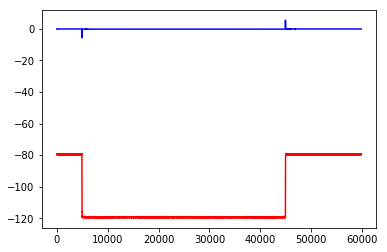

In [5]:
plt.plot(rec[0][0], 'b')
plt.plot(rec[0][1], 'r')

Even traces are current, odd traces the corresponding (recorded) voltage. Protocol voltage is not available in ATF, but easy enough to deduce with these step protocols. Besides, for I-V analysis, it's better to use the achieved voltage rather than the command voltage anyway.

To finish this exploration, here's the extended load function:

In [6]:
def read_2channel_ATF(filename, current_factor = 1, voltage_factor = 1):
    rec = stfio.read(filename)
    rec.current = [rec[0][k].asarray() * current_factor for k in range(0, len(rec[0]), 2)]
    rec.voltage = [rec[0][k].asarray() * voltage_factor for k in range(1, len(rec[0]), 2)]
    return rec

Notes tell me that until 2017-12-06_0018, the current scale was set incorrectly, such that one unit of current in the file corresponds to 2 μA. We can fix that right here:

In [7]:
rec = read_2channel_ATF(filebase.replace('%n', str(fileno).zfill(4)), current_factor = 0.5)

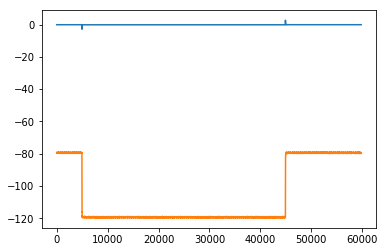

In [8]:
plt.plot(rec.current[0])
plt.plot(rec.voltage[0])

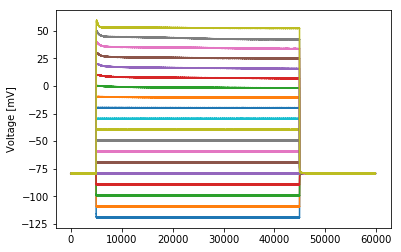

In [9]:
for V in rec.voltage:
    plt.plot(V)
plt.ylabel('Voltage [mV]');

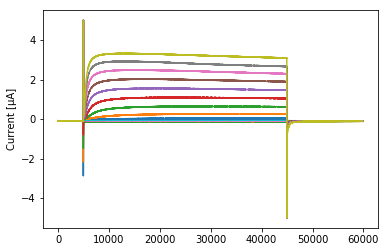

In [10]:
for I in rec.current:
    plt.plot(I)
plt.ylabel(u'Current [μA]');

Okay, all set! Time isn't too important here, but for what it's worth, this is a 40 kHz recording (see rec.dt == 2.5e-5, which is in seconds, not milliseconds!). Let's first have a look at the current-voltage relationship. For that, we need to know where the capacitance spike ends:

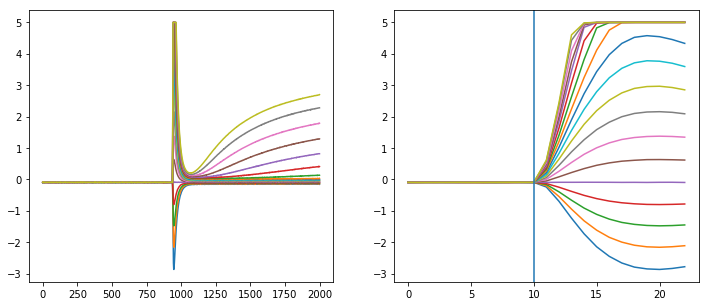

In [11]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
for I in rec.current:
    plt.plot(I[4000:6000])
    
plt.subplot(1,2,2)
for I in rec.current:
    plt.plot(I[4927:4950])
    
rec_step_t0 = 4937
plt.axvline(rec_step_t0 - 4927)

Looks like 5200 (= 1200 + 4000) is a safe enough bet. At the end of the step, we'll also shave off some 200 samples for good measure. Let's check out what the I-V-plot looks like!

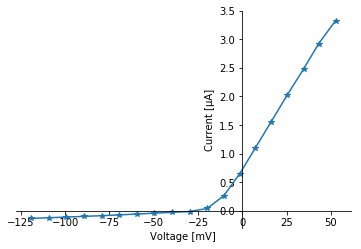

In [12]:
steadystate_limits = (5200, 44800)
peak_currents = [np.max(I[steadystate_limits[0]:steadystate_limits[1]]) for I in rec.current]
median_voltages = [np.median(V[steadystate_limits[0]:steadystate_limits[1]]) for V in rec.voltage]

fig, ax = plt.subplots()
IVplot(peak_currents, median_voltages, ax)

The first thing to do is to find the leak current and subtract it. For that, we'll focus on the lower end of the steps, between -120 and -60 mV, and with the steady-state current rather than the maximum.

In [13]:
def fit_IV(currents, voltages, params, postfix):
    '''
    Fits the conductance and equilibrium potential to the I-V relationship, depositing results as "g_$postfix$",
    "E_$postfix$", and function "I_$postfix$" in the params dict.
    '''
    fit = np.polyfit(voltages, currents, 1)
    params[str('g_$').replace('$', postfix)] = fit[0] # mS
    params[str('E_$').replace('$', postfix)] = -fit[1] / fit[0] # mV
    params[str('I_$').replace('$', postfix)] = lambda V: V*fit[0] + fit[1]

g_leak:  0.0012417884392659428 mS
E_leak:  -4.234642419379304 mV


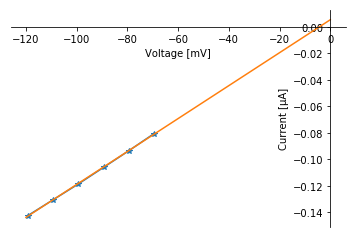

In [14]:
median_voltages = [np.median(V[5200:44800]) for V in rec.voltage]
median_currents = [np.median(I[5200:44800]) for I in rec.current]
    
leak_traces = [i for i in range(len(median_voltages)) if median_voltages[i] <= -60]
leak_currents = [median_currents[i] for i in leak_traces]
leak_voltages = [median_voltages[i] for i in leak_traces]
fit_IV(leak_currents, leak_voltages, params, 'leak')

fig, ax = plt.subplots()
IVplot(leak_currents, leak_voltages, ax)

leak_plot_V = np.array([-120, 0])
ax.plot(leak_plot_V, params['I_leak'](leak_plot_V))

print 'g_leak: ', params['g_leak'], 'mS'
print 'E_leak: ', params['E_leak'], 'mV'

Looks pretty convincing!

With the leak current subtracted, the full I-V plot looks a little nicer:

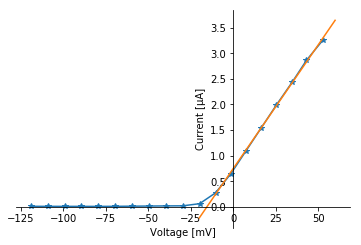

In [15]:
peak_currents_noleak = [peak_currents[i] - params['I_leak'](median_voltages[i]) for i in range(len(peak_currents))]

fig, ax = plt.subplots()
IVplot(peak_currents_noleak, median_voltages, ax)

K_trace_first = 13
K_peak_currents = peak_currents_noleak[K_trace_first:]
K_peak_voltages = median_voltages[K_trace_first:]

K_fit = np.polyfit(K_peak_voltages, K_peak_currents, 1)
def I_K_max (V):
    return V*K_fit[0] + K_fit[1]

K_plot_V = np.array([-20, 60])
ax.plot(K_plot_V, I_K_max(K_plot_V))

It looks as though the potassium equilibrium potential is around -20 mV, definitely not the value I expected. Let's have a look at the tail current protocol instead.

In [16]:
rec2 = read_2channel_ATF(filebase.replace('%n', str(fileno + 1).zfill(4)), current_factor = 0.5)

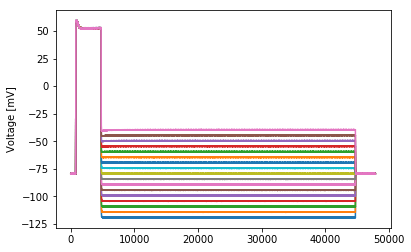

In [17]:
for V in rec2.voltage:
    plt.plot(V)
plt.ylabel('Voltage [mV]');

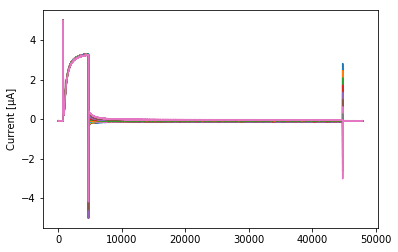

In [18]:
for I in rec2.current:
    plt.plot(I)
plt.ylabel(u'Current [μA]');

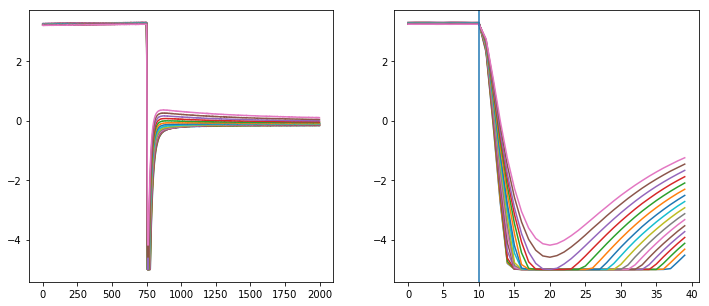

In [19]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
for I in rec2.current:
    plt.plot(I[4000:6000])
    
plt.subplot(1,2,2)
for I in rec2.current:
    plt.plot(I[4740:4780])
    
rec2_step_t0 = 4750
plt.axvline(rec2_step_t0 - 4740)

4881


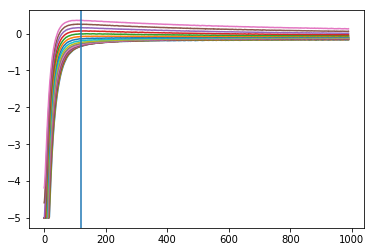

In [20]:
tail_start = rec2_step_t0
tail_min = np.argmin(rec2.current[-1][tail_start:tail_start+1000]) + tail_start
for I in rec2.current:
    plt.plot(I[tail_min:tail_start+1000])

tail_cut = np.argmax(rec2.current[-1][tail_min:tail_start+1000]) + tail_min
plt.axvline(tail_cut - tail_min)
print tail_cut

These tails are, of course, a combination of the potassium tail currents and the capacitive spike. Since the latter is as yet uncharacterised (and even if, a subtraction would likely be inaccurate because of unaccounted-for electrode dynamics), the best way to get the full tail current right at the step to target voltage is to extrapolate the current decay back in time to the step onset (at approx. 4760).

The decay is exponential towards the leak current. We could subtract that if we had sufficient trust in our fit - or simply make sure the tails decay to a zero median at the end, if we don't:

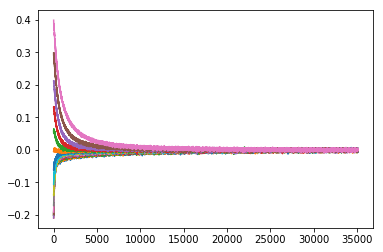

In [21]:
tail_voltages = [np.median(rec2.voltage[i][10000:40000]) for i in range(len(rec2.voltage))]
tails = [np.array(I[tail_cut:40000]) - np.median(I[40000:44000]) for I in rec2.current]

for T in tails:
    plt.plot(T)

In [22]:
decay = lambda t, tau, a: a*np.exp(-t/tau)
err = lambda p, x, y: (decay(x, p[0], p[1]) - y)
tau, a = [], []
t = np.arange(len(tails[0])) + tail_cut - tail_start
for i in range(len(tails)):
    ret = scipy.optimize.least_squares(err, (tau[-1], a[-1]) if i>0 else (4000,-0.05), args=(t, tails[i]))
    tau.append(ret.x[0])
    a.append(ret.x[1])
print a
print tau

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


[-0.04794241900491684, -0.04772076256633489, -0.05298255805326286, -0.10770063376006508, -0.18220299074568774, -0.21039352080204599, -0.21097218030424444, -0.18925159806722883, -0.15221247680512437, -0.1048777453946097, -0.04755364427322911, -0.002961560963438466, 0.08560650019103383, 0.15677096383633252, 0.22772907916298385, 0.29811604440784, 0.3644110101178569]
[4592.446470911511, 4140.015923977512, 3019.9588420661735, 830.7177246113228, 410.3693127294197, 347.6827369328143, 341.27061181593297, 362.8289811593347, 413.36786602813265, 490.99017855717847, 749.2882232083606, 7733.799385203471, 446.3515258502988, 627.3168987474087, 826.3277874599847, 1092.9597215031786, 1489.27764393229]


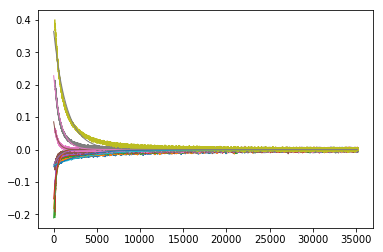

In [23]:
t_ext = np.arange(len(tails[0]))
for i in range(0, len(tails), 2):
    plt.plot(t, tails[i])
for i in range(0, len(tails), 2):
    plt.plot(t_ext, decay(t_ext, tau[i], a[i]), linewidth=1)

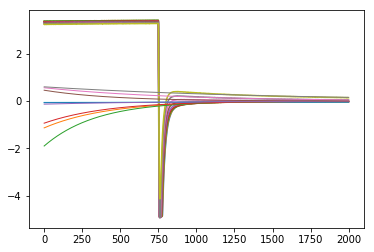

In [24]:
t_ext = np.arange(2000)
for i in range(0, len(tails), 2):
    plt.plot(rec2.current[i][4000:6000] - params['I_leak'](tail_voltages[i]))
for i in range(0, len(tails), 2):
    plt.plot(t_ext, decay(t_ext+4000-tail_start, tau[i], a[i]), linewidth=1)

Looks like a reasonable-ish fit. Let's see the I-V curve at the step:

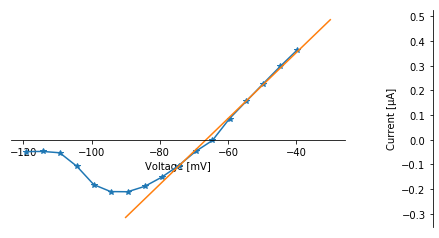

In [25]:
tail_t0 = [decay(0, tau[i], a[i]) for i in range(len(tails))]
fig, ax = plt.subplots()
IVplot(tail_t0, tail_voltages, ax)

tail_fit_from = 8
fit_IV(tail_t0[tail_fit_from:], tail_voltages[tail_fit_from:], params, 'K')

tail_plot_V = np.array([-90, -30])
ax.plot(tail_plot_V, params['I_K'](tail_plot_V))

Oh hey, this current rectifies, who knew! But at least the reversal potential looks more like what I'd expect here.

In [26]:
print params

{'I_K': <function <lambda> at 0x65cf6e0>, 'g_leak': 0.0012417884392659428, 'I_leak': <function <lambda> at 0x5a89500>, 'g_K': 0.013356231128590917, 'E_K': -66.4100256932235, 'E_leak': -4.234642419379304}
